<a href="https://colab.research.google.com/github/Rogerio-mack/Temporal/blob/main/cap6_aprendizado_de_maquina_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Bibliotecas básica a serem importadas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults
import statsmodels.api as qqplot
import scipy.stats as stats

# **4. Modelos de Predição ARMA e ARIMA**
---

Neste capítulo, você irá aprender:

1. O uso dos modelos ARMA e ARIMA para fazer previsões.
2. Analisar os resíduos do ajuste dos modelos ARMA e ARIMA.
3. O uso da *library statsmodels* para ajustar modelos ARIMA




Neste capítulo, você vai estudar os modelos Autorregressivos Integrados de médias móveis (ARIMA) amplamente utilizados na literatura para modelar séries temporais estacionárias e/ou não estacionárias (com tendência estocástica) visando fazer previsões e/ou descrever o comportamento dos dados. A ideia principal da estrutura destes modelos consiste em modelar a dependencia serial dos dados, uma vez que, na prática, na maioria das séries, observa-se que os valores recentes estão correlacionados com seus valores passados e que a força dessa dependência diminui (ou aumenta) quando considerados valores mais distantes no tempo. Imagine que desejamos prever a taxa de câmbio do dólar, assim, é razoável pensar que o valor de amanhã está correlacionado com os valores observados recentemente e que essa correlação diminui conforme nos afastamos no tempo.

O modelo ARIMA pode ser analisando decompondo-o em três partes: AR(parte Autorregressiva), I (parte integrada) e MA (Médias móveis). Seja $Y_t$ o valor observado de uma série no instante $t$. 

*   A parte autoregressiva permite modelar, por meio de valores defasados da série ($Y_{t-i}$), a dependencia serial do valor atual ($Y_t$) com $p$ valores passados da série $(Y_{t-1},...Y_{t-p})$. Assim, as previsões serão baseadas em valores passados da série.

*   Na prática, a maioria das séries apresentam padrões de crescimento ou decrescimento em alguns períodos de tempo. Estas séries podem tornar-se estacionárias por meio de um número finito (geralmente um ou dois) diferenças. A parte integrada, refere-se ao número de diferenças necessárias para tornar a série em estacionária. 

*   As médias móveis modelam a série temporal por meio de uma combinação linear de ruídos branco ( valores independentes com média zero e  variância constante). Sua interpretação é menos intuitiva e geralmente esses termos são adicionados no modelo para diminuir o número de termos defasados na parte AR.


Em geral, os modelos ARIMA permitem modelar processos chamados de não estacionários homogêneos, denotado por ARIMA(p,d,q), em que $d$ indica o número de diferenças necessárias para que a série $Y_t$ se torne estacionária, $p$ é o número total de termos defasados da série que serão considerados na parte AR e $q$ o número total de erros aleatórios defasados que serão considerados na parte MA. Assim, o modelo ARIMA pode ser representado como:

$$W_t=\underbrace{\Delta^d Y_t}_\text{série após d diferenças}$$


$${W_t} =\phi_0+ \underbrace{\phi_1 W_{t-1}+ \phi_2 W_{t-2}+...+\phi_p  W_{t-p}}_\text { p - termos autorregressivos} +\underbrace{\theta_1e_{t-1}+ \theta_2 e_{t-2}+...+ \theta_q e_{t-q}}_\text{ q- termos de Médias móveis} + e_t , $$

em que $\phi_1,...,\phi_p, \theta_1,...,\theta_q$ são valores a serem estimados e, geralmente, o ruído branco, $e_t$, segue uma distribuição Normal.  Antes de estudar os modelos ARIMA, devemos primeiro discutir o conceito de estacionariedade e a técnica de diferenciação de séries temporais.

## Conceitos importantes 


A seguir vamos discutir o conceito de estacionariedade, as funções de autocorrelação e o método de diferenciação. Por meio de exemplos discutiremos sua importância no ajuste de modelos ARIMA. 
Nesta seção analisaremos três séries temporais: 

- Exportação trimestral de bens e serviços no Brasil, valores a preços correntes (Milhões de Reais) no período de janeiro de 1996 a dezembro de 2021.
- Índice mensal do volume de vendas de materiais de construção no Brasil no período de janeiro de 2005 a dezembro de 2015.
- Variação diária da cotação do dólar em relação ao real de julho de 2018 a dezembro de 2019.

In [ ]:
# Séries temporais
df1=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/Series.xlsx", sheet_name="Exportações") #IBGE - Trimestral
df2=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/Series.xlsx", sheet_name="dolar") #Economial UOL - diária
df3=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/Series.xlsx", sheet_name="Vendas") #IBGE - mensal

In [ ]:
print("Exportação de bens e serviços \n \n", df1.head(),"\n")
print("Volume de vendas de materiais de construção \n \n",df3.head(),"\n")
print("Variação diária da cotação do dólar \n \n", df2.head(),"\n")

Exportação de bens e serviços 
 
               trimestre   ano  Exportações
1996-03-31  1 trimestre  1996        12306
1996-06-30  2 trimestre  1996        14576
1996-09-30  3 trimestre  1996        15560
1996-12-31  4 trimestre  1996        15085
1997-03-31  1 trimestre  1997        13162 

Volume de vendas de materiais de construção 
 
                       data  volume_vendas
2005-01-31    janeiro 2005           59.8
2005-02-28  fevereiro 2005           51.5
2005-03-31      março 2005           58.8
2005-04-30      abril 2005           57.5
2005-05-31       maio 2005           57.3 

Variação diária da cotação do dólar 
 
                  data   Var
2018-07-02 2018-07-02  0.93
2018-07-03 2018-07-03 -0.40
2018-07-04 2018-07-04  0.42
2018-07-05 2018-07-05  0.48
2018-07-06 2018-07-06 -1.78 



### Estacionariedade




Em **processos estacionários** a média e a variância são constantes ao longo do tempo, intuitivamente isto significa que as observações se desenvolvem aleatoriamente em torno de um certo nível com variabilidade constante.

#### Exemplo.

A seguir apresentam-se os gráficos das três séries apresentadas anteriormente

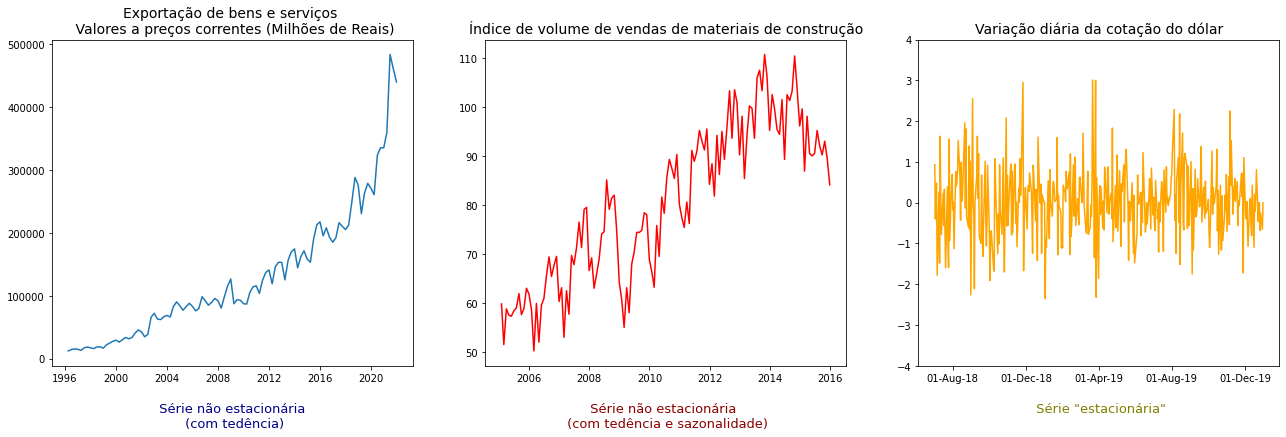

In [ ]:
#Gráficos das séries

index_dates1 = pd.date_range(start='3/1/1996', end='12/31/2021', freq='3M')
index_dates2 = pd.date_range(start='7/2/2018', end='12/31/2019', freq='B')
index_dates3 = pd.date_range(start='1/1/2005', end='12/31/2015', freq='M')

df1.index=index_dates1
df2.index=index_dates2
df3.index=index_dates3

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(22,6))
ax1.plot(df1.index, df1.Exportações)
ax1.set_title('Exportação de bens e serviços \n Valores a preços correntes (Milhões de Reais)',fontdict = {'fontsize' : 14})
ax1.set_xlabel('\n Série não estacionária \n (com tedência)',fontdict = {'fontsize' : 13},color="darkblue")

ax2.plot(df3.index, df3["volume_vendas"], c='r')
ax2.set_title('Índice de volume de vendas de materiais de construção',fontdict = {'fontsize' : 14})
ax2.set_xlabel('\n Série não estacionária  \n (com tedência e sazonalidade)',fontdict = {'fontsize' : 13},color="darkred")


ax3.plot(df2.index.to_pydatetime(), df2["Var"], c='orange')
ax3.xaxis.set_major_locator(mdates.MonthLocator([4,8,12]))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ax3.set_title('Variação diária da cotação do dólar',fontdict = {'fontsize' : 14})
ax3.set_xlabel('\n Série "estacionária"',fontdict = {'fontsize' : 13},color="olive")

ax3.set_ylim([-4, 4]);

Observa-se que a única série, aparentemente, estacionária é a variação diária do dolar cujos valores estão na faixa de -3 a 3. As outras duas séries apresentam tendência crescente e o volume de vendas de materias de construção um comportamento sazonal que aparentemente se repete a cada ano. 

### Função de autocorrelação

No processo de identificação de modelos ARIMA, a análise da estrutura de dependência serial dos dados é fundamental. Em algumas séries, observa-se que o valor atual está correlacionado com seus valores passados e a força dessa dependência diminui quando considerados valores mais distantes no tempo. Essas defasagens são também chamadas usualmente de "lags".


A função de autocorrelacão (ACF) permite visualizar as correlações entre observações distantes $k$ períodos de tempo. Assim, para um "lag=1" representa-se como valores sucessivos da série estão correlacionados. Cabe ressaltar que para "lag=0" o valor da correlação sempre será um, por que?

Na função de autocorrelação amostral, função usada para ajudar a identificar um modelo ARIMA,  intervalos de confiança de 95% são traçados para verificar se as autocorrelações são significativamente diferentes de zero.

**Observação!** Recomenda-se analisar o ACF de **série estacionárias**. As séries **não estacionárias** possuem um ACF com decaimento muito lento e não é possível analisar seus valores uma vez que as tendências e/ou sazonalidades não permitem estudar se de fato valores distantes $k$ períodos de tempo estão relacionados ou não.

#### **Exemplo**. 
A seguir apresenta-se o ACF de uma série (simulada) cujos valores sucessivos estão correlacionados. A série foi gerada de tal forma que a correlação entre o valor no instante $t$ e $t-1$ seja de $0,7$. Note que a correlação da série no instate $t$ e $t-k$ diminuiu quando $k$ aumenta, i.e, quando analisamos a correlação da série no instante $t$ com valores mais distantes no tempo. Faz sentido, não?

In [ ]:
# Simulando uma série com valores sucessivos autocorrelacionados
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_process import ArmaProcess
ar1 = np.array([1,-0.7])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1,ma1)
simulated_data = AR_object1.generate_sample(nsample=1000);


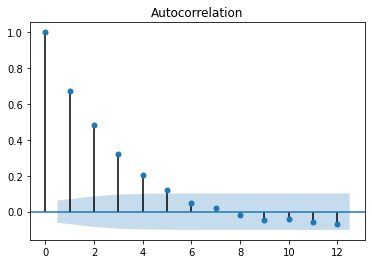

In [ ]:
# Gráfico do ACF
from statsmodels.graphics.tsaplots import plot_acf
x=plot_acf(simulated_data, lags=12)

Note que a correlação que considera valores sucessivos ($Z_t$ e $Z_{t-1}$, ou seja, $lag=1$) é de, aproximadamente, 0,7 e essas correlações decaem exponencialmente quando analisadas as associações entre valores mais distantes. Observa-se que para valores "muito" distantes no tempo (lags >7) a correlação é zero estatísticamente falando. 

Cuidado novamente na interpretação deste gráfico uma vez que há um efeito "bola de neve" nas correlações, por exemplo, se um valor no instante $t$ está correlacionado com o valor do instante anterior ($t-1$), então, por sua vez o valor do instante ($t-1$) está correlacionado com seu instante $t-2$. Por tanto, temos que o valor no instante $t$ também está correlacionado com o instante $t-2$. 

### Função de autocorrelação parcial (PACF)

As autocorrelações parciais são usadas para mensurar o grau de associação (correlação) entre os valores $Z_{t}$ e $Z_{t-k}$, quando os efeitos das outras defasagens são removidos.

O gráfico PACF para a série simulada é dado a seguir:

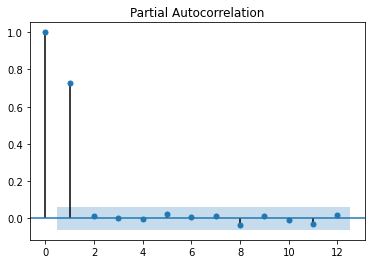

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
x=plot_pacf(simulated_data, lags=12);

Observa-se que somente a correlação do lag=1 é significativamente diferente de zero. Em um modelo de previsão podemos entender este resultado como  o valor da série no instante $"t"$ pode ser previsto usando a informação contida no instante $"t-1"$.

### Diferenciação

Muitas séries analisadas na prática são não estacionárias, mas ao tomarmos algumas diferenças a série se torna estacionária.  Tomando-se uma diferença elimina-se uma tendência linear. 




Seja $Z_t$ o valor da série no instante $t$. A primeira diferença é dada por:

$$ \Delta Z_t = Z_t -Z_{t-1} $$

Em geral, tomar uma ou duas diferenças é suficiente para eliminar tendências da série e torná-la estacionária.

Quando a série é sazonal  é apropriado tomar as diferenças para o período de
sazonalidade. Considere o caso de uma série mensal cujos valores apresentam um comportamento períodico que se repete a cada ano. Assim, recomenda-se tomar uma diferença sazonal do tipo:

$$ \Delta Z_t = Z_t -Z_{t-12} $$


#### **Exemplo**. 

A série trimestral Exportação de bens e serviços no Brasil apresenta uma tendência crescente, vamos aplicar uma diferença para visualizar o efeito.

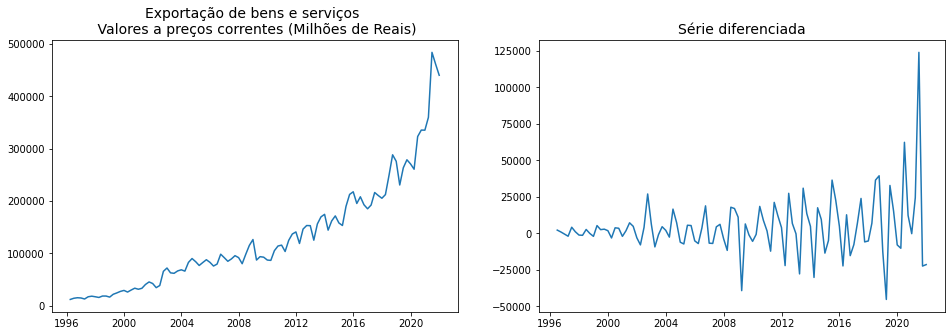

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
ax1.plot(df1.index, df1.Exportações)
ax1.set_title('Exportação de bens e serviços \n Valores a preços correntes (Milhões de Reais)',fontdict = {'fontsize' : 14})

ax2.plot(df1.index, df1.Exportações.diff())
ax2.set_title('Série diferenciada',fontdict = {'fontsize' : 14})

plt.show()

Observa-se que a série diferenciada varia em torno de zero. Destaca-se um aumento da variabilidade ao longo do tempo, um possível procedimento recomendado nestes casos é aplicar a função logaritmo, antes de diferenciar a série, e modelar os valores transformados.

## Modelos Autoregressivos
Denotação: AR(p), modelo autoregressivo de ordem p. 

A estrutura dos modelos AR e, portanto, suas previsões são baseadas na modelagem da dependencia serial dos dados. Seja $Y_t$ o valor da série no instante $t$, os modelos AR(p) definem que $Y_t$ pode ser estimado por meio de uma combinação linear de $p$ valores passados da série mais um erro, no qual se incorpora tudo aquilo que não é explicado pelo histórico considerado. Assume-se que esses erros são independentes e se desenvolvem de forma aleatória em torno de zero com variância constante. O modelo AR(p) é dado por



$$Y_t=\phi_1Y_{t-1}+ \phi_2Y_{t-2}+...+ \phi_pY_{t-p} +e_t,$$

em que $\phi_1,...,\phi_p$ são valores a serem estimados, usaremos a biblioteca *statsmodels* de pyhton para isto, e $e_t$ um ruído branco que segue, geralmente, uma distribuição Normal. Para garantir estacionariedade (média e variância finita e invariantes no tempo) restrições sobre seus parâmetros devem ser adotadas, ver mais detalhes em Morettin e Toloi (1985). 

Uma vantagem de você implementar os modelos AR(p) é poder mensurar o "peso" ($\phi_i$) que um valor defasado ($Y_{t-i}$) representa na estimação do valor atual (instante $t$) da série $(Y_t)$. Assim, você pode perceber que para prever o valor de amanhã, em uma série diária, os valores de ontem e de há uma semana são importantes, porém, o valor de ontem pode ser, por exemplo, 5 vezes mais "informativo".

O modelo AR(P) pode ser escrito usando o operador autoregressivo L isto será útil se você deseja entender a estrutura do código de Python usado pela biblioteca *statsmodels* para ajustar os dados.

$$(1-\phi_1L-\phi_2L^{2}-...-\phi_pL^{p})Y_t= e_t,$$

o operador $L$ facilita a escrita e pode ser entendido como: $L^{p}Y_{t}=Y_{t-p}.$ 

**Exemplo**. O modelo AR(1) é dado por:

$$Y_t =\phi_0+\phi_1 Y_{t-1} +e_t,$$


Para que o processo seja estacionário (média e variância finita) é necessário que $|\phi_1|<1$. Finalmente, a função de autocorrelação (ACF) de um modelo AR(1) é da forma $$\rho_k=\phi_1^k, k≥0$$  em que $\rho_k$ representa a autocorrelação entre as observações com defasagens $k$ e $k−1$. Assim, para valores consecutivos ($Y_t$ e $Y_{t-1}$) a correlação entre eles é de $\phi_1$. Veremos, via simulação, que conforme $k$ aumenta a ACF decai exponencialemnte quando $\phi_1>0$. 
Analisar a função ACF é importante para identificar os modelos AR.



### Simulando modelos AR(p)

Vamos simular aqui um processo autorregressivo AR(1) com diferentes valores de $\phi_1$ para visualizar seu comportamento e suas funções de autocorrelação (ACF) e autocorrelação parcial (PACF). Destaca-se que para que a série seja estacionária é necessário que $|\phi_1|<1$ para mais detalhas ver Morettin(1983).


In [ ]:
import ipywidgets as widgets

def f(phi=0.7):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,4))
  np.random.seed(2000)
  ar1 = np.array([1,-phi])
  simulated_data_1 = ArmaProcess(ar1).generate_sample(nsample=500)

  ax1.plot(simulated_data_1)
  ax1.title.set_text('Série')
  plot_acf(simulated_data_1, ax=ax2, title="ACF")
  y=plot_pacf(simulated_data_1, ax=ax3, title="PACF")

w = widgets.interactive(f, phi=(-0.99, 0.99, 0.1))
display(w)

interactive(children=(FloatSlider(value=0.7, description='phi', max=0.99, min=-0.99), Output()), _dom_classes=…

A série simulada tem 500 observações com média zero. Nota-se que os valores se desenvolvem de forma aleatória em torno da média com variância constante, comportamento esperado uma vez que $\phi_1 \in (0,1)$. A função ACF mostra que a correlação serial decresce de forma exponencial cuja correlação amostral entre os valores dos instantes $t$ e $t-1$ é de, aproximadamente, $\phi_1$ e na função PACF observa-se que somete o lag 1 é significativamente diferente de zero cujo valor cujo o valor amostral corresponde, aproximadamente, ao valor de $\phi_1$ selecionado na simulação. 

Na prática, recomenda-se analisar a função PACF para identificar o modelo AR(p) uma vez que  somente os $p$ primeiros lag, correlações entre instantes $t$ e $t-i, i=1,2,...,p$ são significativamente diferente de zero. A função ACF destes modelos apresentam  um decresciemento exponencial e/ou comportamentos parecidos com o das funções seno e coseno dependendo do sinal do parâmetro $\phi_1$.

Na identificação de um modelo AR($p$) uma abordagem comumente usada consiste em analisar a função de autocorrelação parcial (FACP) para sugerir um possível intervalo de valores de $p$. Outra alternativa, amplamente usada na prática, baseia-se no uso de algum critério de informação, por exemplo, AIC e/ou BIC. O procedimento consiste em definir $k$ possíveis valores de $p$ ajustar os $k$ modelos AR e selecionar aquele que apresentou o menor valor de AIC e/ou BIC. Mas detalhes podem ser encontrados em Morettin(1983).

Nos exemplos anteriores fizemos uso da PACF para confirmar que ao avaliar tal função para os modelos AR simulados chegaríamos na correta defasagem do modelo.

## Modelos de Médias móveis
Denotação: MA(q), modelos de médias móveis de ordem q. 

Na estrutura dos modelos MA, assume-se que a série temporal pode ser gerada por meio de uma combinação linear de erros aleatórios. Seja $Y_t$ o valor da série no instante $t$, temos

$$Y_t=a_t-\theta_1e_{t-1}- \theta_2e_{t-2}-...- \theta_qe_{t-q},$$

em que $\theta_1,...,\theta_q$ são parâmetros a serem estimados, usaremos a biblioteca $stastmodels$ de pyhton para isto e $e_t$ um ruído branco que segue, geralmente, uma distribuição Normal. Um modelo MA(1) é equivalente a um modelo AR de ordem infinita. Assim, para muitas séries encontradas na práticas, se quisermos um modelo AR com um número não muito grande de parâmetros, a inclusão de termos de médias móveis é uma solução adequada. Na seguinte seção, você vai ver a estrutura dos modelo ARMA que consideram termos AR e de MA. 

Uma característica interessante de um processo MA(q) é sua função ACF cujos valores são iguais a zero para "lags"maiores do que $q$. Assim, você poderia pensar em implementar um modelo MA(1) para modelar sua série se, por exemplo, você verifica que o valor da série no instante t, $Y_t$ só depende (está correlacionado) com o valor imediatamente anterior ($Y_{t-1}).$

**Exemplo.** O modelo MA(1) é dada por:

$$Y_t= \theta_0 -\theta_1 e_{t-1}+e_t$$

Neste modelo não há restrições dos parâmetros para garantir estacionaridade (média e variância finita). De fato, a média e variância dos processos de médias móveis sempre serão constantes. A função de autocorrelação, ACF,  é dada por:
$$\rho_1=\frac{\theta_1}{(1+\theta_1^2)}$$ e $$\rho_k=0, k>1.$$

O comportamento que você observa na ACF do modelo MA(1)  também se observa nos modelos MA(q) com $q>1$, isto é, os únicos valores de $\rho_k$ diferentes de zero são as correlações referentes às primeiras $q$ defasagens. Desta forma, podemos usar a função de autocorrelação como uma boa alternativa para definir a defasagem ($q$) de um processo de médias móveis (MA($q$)).


 

### Simulando modelos MA(q)

In [ ]:
import ipywidgets as widgets

def f(theta=0.8):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,4))
  np.random.seed(2000)
  ar1 = np.array([1])
  ma1 = np.array([1,theta])
  simulated_data_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=600)

  ax1.plot(simulated_data_1)
  ax1.title.set_text('Série')
  plot_acf(simulated_data_1, ax=ax2, title="ACF")
  y=plot_pacf(simulated_data_1, ax=ax3, title="PACF")

w = widgets.interactive(f, theta=(-0.9, 0.9, 0.1))
display(w)

interactive(children=(FloatSlider(value=0.8, description='theta', max=0.9, min=-0.9), Output()), _dom_classes=…

As séries simuladas têm 500 observações com média zero. Nota-se que os valores da série se desenvolvem de forma aleatória em torno da média. Nestas simulações consideramos que $\theta \in (0,1)$. No entanto, verifiquem que esse comportamento se mantêm para outros valores fora desse intervalo.

Observa-se na função ACF amostral que somete o lag 1 é significativamente diferente de zero. Vale salientar que o valor téorico de $\phi_1$ é $\frac{\theta_1}{1+\theta_1^2}$. Por fim, nota-se que a função PACF decresce exponencialmente cujos valores variam de positivo a negativo. 

Na prática, recomenda-se analisar a função ACF para identificar o modelo MA(q). Essa conclusão é diferente do que encontramos para os modelos autorregressivos (AR) onde a função de autocorrelação parcial (PACF) permite definir a defasagem do processo.

## Modelos Autoregressivos e de médias móveis
Denotação: ARMA(p,q). Modelos ARMA de ordem p e q.

Se considerarmos um modelo formado pela parte Autoregressiva (AR) e de Médias móveis (MA), vamos ter um modelo mais geral de séries temporais nomeado ARMA. Na estrutura dos modelos ARMA(p,q) incorporam-se $p$ valores defasados da série e $q$ valores defasados de erros aleatórios. Seja  $Y_t$ o valor da série no instante $t$, temos

$$Y_t=\phi_1Y_{t-1}+ \phi_2Y_{t-2}+...+ \phi_pY_{t-p}-\theta_1e_{t-1}- \theta_2e_{t-2}-...- \theta_qe_{t-q}+e_t,$$

em que $e_t$ é ruído branco com média zero. Na prática, incorporam-se termos de médias móveis para diminuir o número de termos autorregressivos no modelo e melhorar o ajuste.

**Exemplo**. O modelo ARMA(1,1) é dado por:

<center>$Y_t= \phi_0+ \phi_1 Y_{t-1}- \theta_1e_{t-1}+e_t$ </center>
As restrições de estacionariedade são iguais às modelo AR(1), isto é, $|\phi_1|<1$.
A função de autocorrelação, ACF, do modelo ARMA(1,1) se comporta muito semelhante à FAC do AR(1) exceto pelo fato que o seu decaimento inicia na defasagem 2.

### Simulação modelos ARMA (p,q)

In [ ]:
import ipywidgets as widgets

def f(theta=0.3, phi=0.6):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,4))
  np.random.seed(2000)
  ar1 = np.array([1, -phi])
  ma1 = np.array([1,theta])
  simulated_data_1 = ArmaProcess(ar1,ma1).generate_sample(nsample=600)

  ax1.plot(simulated_data_1)
  ax1.title.set_text('Série')
  plot_acf(simulated_data_1, ax=ax2, title="ACF")
  y=plot_pacf(simulated_data_1, ax=ax3, title="PACF")

w = widgets.interactive(f, theta=(0.1, 0.9, 0.1), phi=(-0.9, 0.9, 0.1))
display(w)

interactive(children=(FloatSlider(value=0.3, description='theta', max=0.9, min=0.1), FloatSlider(value=0.6, de…

As séries simuladas têm 500 observações com média zero. Nota-se que se desenvolvem de forma aleatória em torno da média. Observa-se no exemplo, ARMA(1,1) com $\phi_1=0,6$ e $\theta_1=0,3$ que a correlação serial decresce exponencialmente e a função PACF mostra que os três primeiros lags são siginificativamente diferente de zero. O primeiro lag é um pouco maior que o valor de $\phi_1$.

Apesar dos modelos ARMA(p,q) serem combinações lineares de modelos AR(p) e MA(q), o comportamento das funções de autocorrelação e autocorrelação parcial não necessáriamente estarão em conformidade com o que estudamos para os modelos AR e MA. Desta forma, faz-se necessário o uso de critérios de seleção, por exemplo, o Akaike’s Information Criterion (AIC) e o Bayesian Information Criterion (BIC) para a seleção das ordens do modelo ARMA(p,q)



## Modelos Autoregressivos integreados e de médias móveis


Denotação: ARIMA(p,d,q). Modelos ARMA de ordem p e q com d diferenças.

Os modelos ARIMA são capazes de descrever o comportamento de séries estacionárias ou não estacionárias homogêneas, isto é, séries que não apresentam comportamentos explosivos. Uma característica dos processos estacionários homogênos é que a inclinção ou nível da série muda ao longo do tempo. Assim, se você deseja fazer previsões e/ou entender o comportamento dos dados ao longo do tempo os modelos ARIMA são uma boa opção.

Um exemplo de um processo não estacionário homogêneo é um processo AR(1) com $\phi_1=1$, chamado de passeio aleatório.

Na aplicação dos modelos ARIMA(p,d,q) primeiro realizam-se $d$ diferenças para que a série se torne estacionária ($d=0$ indica que a série de interesse é estacionária e portanto não é necessário aplicar diferenças), $p$ indica o número total de termos defasados da série (parte AR) que serão considerados e $q$ o número total de termos defasados de erros aleatórios correspondente à parte de Médias móveis (MA) cuja interpretação é menos intuitiva. Seja $Y_t$ o valor da série no instante $t$, temos

<center> $X_t= \Delta^d Y_t$ </center>

<center> $X_t=\phi_1X_{t-1}+ \phi_2X_{t-2}+...+ \phi_pX_{t-p}-\theta_1e_{t-1}- \theta_2e_{t-2}-...- \theta_qe_{t-q}+e_t$

Quando $d=1$, temos que, $X_t=\Delta^1 Y_t= Y_t - Y_{t-1}$

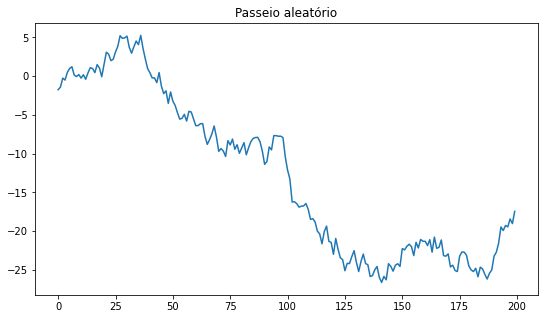

In [ ]:
# Simulação de um passeio aleatório

ar1 = np.array([1,-1])
np.random.seed(100)
simulated_data_2 = ArmaProcess(ar1).generate_sample(nsample=200)

plt.figure(figsize=(9,5))
plt.plot(simulated_data_2)
plt.title("Passeio aleatório");

**Exemplo** O modelo ARIMA(1,1,1) é dado por

<center> $X_t = Y_t-Y_{t-1}$ </center>
<center> $X_t=\phi_1X_{t-1}-\theta_1e_{t-1}+e_t$


Nota-se que após uma diferença é ajustado um modelo ARMA(1,1)

### Pasos ajustar um modelo ARIMA

1. Verificar se a série é estacionária. Um procedimento simples consiste em plotar os valores observados da série ao longo do tempo e verificar se há tendências ou sazonalidadades (comportamentos de séries não estacionárias). Quando visualmente não é possível determinar se a série é ou não estacionária pode-se aplicar o teste de raizes unitárias Dickey-Fuller. Para eliminar tendências pode-se diferenciar a série ou ajustar retas de tendências por meio de polinômios. 

2. Com a série estacionária, após d diferenças, selecionam-se possíveis valores de p e q com ajuda das funções ACF e PACF. 

3. Ajustam-se modelos ARIMA(p,d,q) com os valores de p, d e q definidos nos dois passos anteriores.

4. Para selecionar o melhor modelo, isto é, aquele que se ajusta melhor aos dados podem-se usar critérios de seleção como AIC, BIC ou GAIC. Aquele modelo que apresentar o menor valor para estes critérios deve ser considerado.

5. Analisar os resíduos do modelo selecionado no passo 4. Deve-se verificar que os resíduos sejam independentes (não correlacionados) pode-se usar um gráfico de ACF para checar este pressuposto, os resíduos devem ter média zero e se desenvolver se forma aleatória em torno deste valor. Por fim, os resíduos devem seguir uma distribuição normal, pressuposto necessário para realizar previsões e construir intervalos de confiança. 

A seguir o fluxograma de ajuste

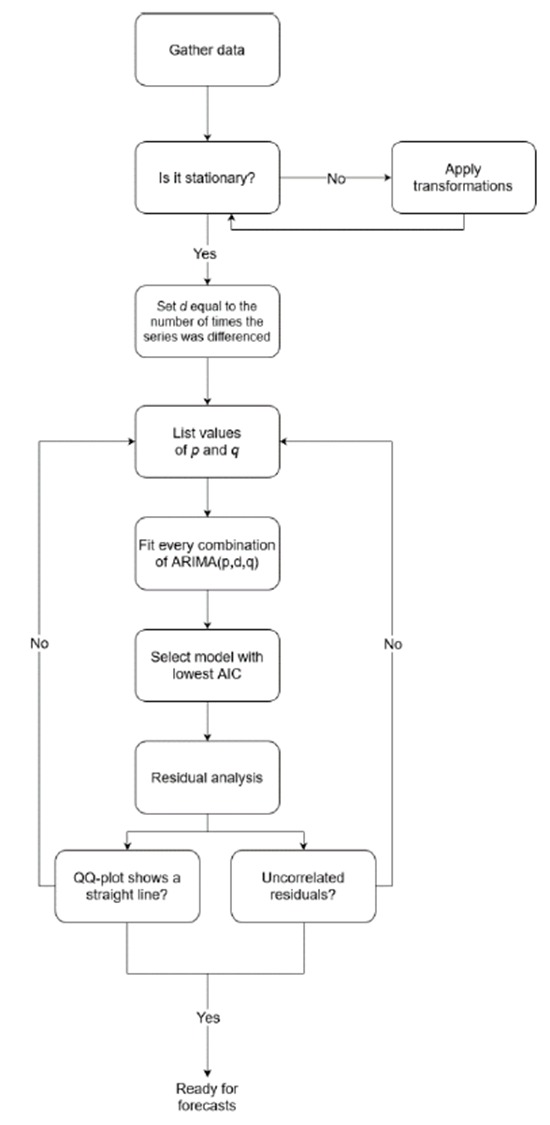

(Vou refazer esse fluxograma)

### Exemplo 1

A seguir apresenta-se a série mensal do preço médio de venda no atacado de óleo de soja refinado (20 unidades) no estado de Paraná. Período de janeiro de 1997 a dezembro de 2019. Valores em Reais (R$). Dados obtidos do site: https://www.agricultura.pr.gov.br/deral/precos.

Os preços variam entre 15,17 reias( registrado em abril de 1997) e 71,77 reais (valor atinguido em setembro de 2019). O interesse neste exercício é mostrar como ajustar uma serie usando os modelos ARIMA(p,d,q) visando fazer previsões a curto prazo usando o histórico da série.

In [ ]:
# Série
df=pd.read_excel("https://www.orlandoalbarracin.com.br/phyton/series_ole_soja.xlsx")
df.head()

,ano,mês,valor
0,1997,janeiro,15.17
1,1997,fevereiro,15.49
2,1997,março,15.73
3,1997,abril,15.56
4,1997,maio,15.65


 A seguir apresenta-se o gráfico da série ao longo do período de estudo e sua função ACF.

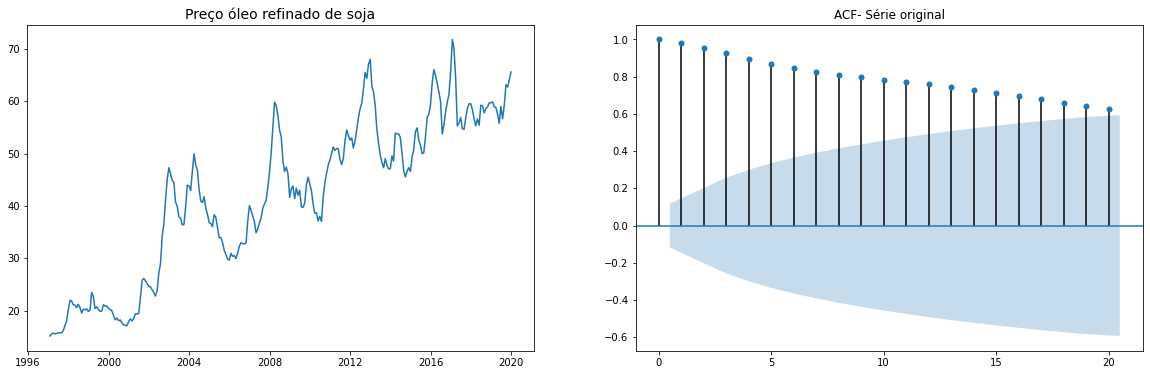

In [ ]:
# Arrumando o eixo-x (série mensal)
index_data = pd.date_range(start='1/1/1997', end='12/31/2019', freq='M')
df.index=index_data

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
ax1.plot(df.index, df.valor)
ax1.set_title('Preço óleo refinado de soja',fontdict = {'fontsize' : 14})


plot_acf(df.valor, lags=20, ax=ax2, title="ACF- Série original")

plt.show()

Observa-se que os preços de venda no atacado de óleo de soja refinado apresentam uma tendência crescente ao longo do período de estudo. Nota-se também que aparentemente há um comportamento sazonal. O ACF da série original apresenta um decrescimento lento, comportamento esperado uma vez que a série não é estacionária. Para eliminar a tendência e tornar a série estacionária realizou-se uma diferença. A série diferenciada se desenvolve, aparentemente, de forma aleatória em torno de zero. Porém, há uma menor variabilidade no começo da série isto é decorrente da pouca variação dos preços nos primeiros anos da série. 

Para verificar os possíveis valores de p e/ou q que podem ser implementados no modelo ARIMA(p,d,q) apresentam-se os gráficos ACF e PACF da série após uma diferença.

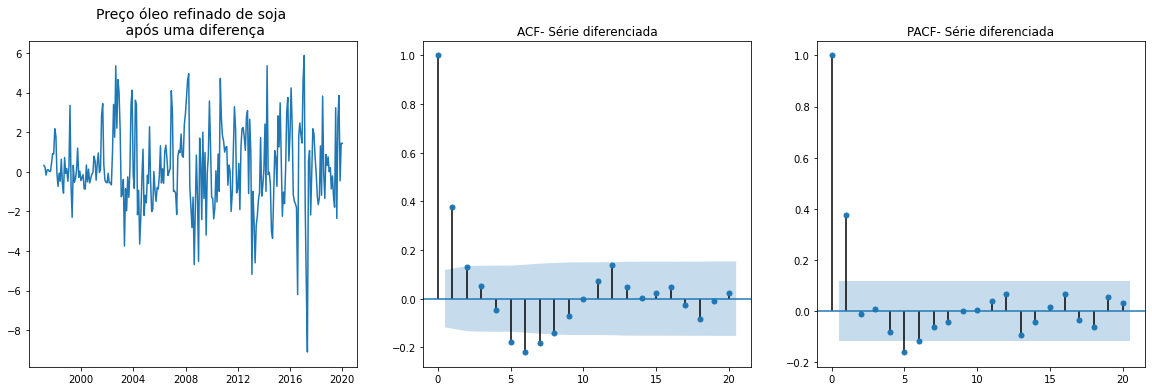

In [ ]:
# Analisando o ACF
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))

ax1.plot(df.index, df.valor.diff())
ax1.set_title('Preço óleo refinado de soja \n após uma diferença',fontdict = {'fontsize' : 14})
y1=plot_acf(df.valor.diff().dropna(), lags=20, ax=ax2, title="ACF- Série diferenciada")
y2=plot_pacf(df.valor.diff().dropna(),ax=ax3, lags=20, title="PACF- Série diferenciada");

No gráfico de PACF observa-se que seria interessante considerar no modelo a informação defassada dos lags 1, 5 e 6 uma vez que são estatísticamente diferente de zero (estão fora do intervalo de confiança). Assim, serão ajustados modelos ARIMA com $p$ e $q$ no intervalo de 0 a 6. Os termos de médias móveis serão considerados para tentar melhorar o ajuste do modelo. Vale ressaltar que nos modelos que serão ajustados estão sendo consideramos modelos só com termos autoregressivos (AR) e/ou com termos de médias móveis (MA). Para selecionar o "melhor" modelo vamos considerar o critério AIC. 
A seguir, apresenta-se o AIC dos modelos ajustados.

In [ ]:
# Separando a série: treinamento e teste

a=len(df.valor)-12
train = df.valor[:a]
test = df.valor[a:]

In [ ]:
# Valores de AIC

import itertools
for i, j in itertools.product(range(6), range(6)):
  print("AIC do modelo","ARIMA(",i,", 1 ,",j,"):",
        round(ARIMA(train, order=(i, 1, j),
                    enforce_stationarity=True,
                    enforce_invertibility=True).fit(method_kwargs={'maxiter':300}).aic,4))

AIC do modelo ARIMA( 0 , 1 , 0 ): 1131.1734
AIC do modelo ARIMA( 0 , 1 , 1 ): 1091.2241
AIC do modelo ARIMA( 0 , 1 , 2 ): 1088.9615
AIC do modelo ARIMA( 0 , 1 , 3 ): 1090.6947
AIC do modelo ARIMA( 0 , 1 , 4 ): 1090.6036
AIC do modelo ARIMA( 0 , 1 , 5 ): 1092.4909
AIC do modelo ARIMA( 1 , 1 , 0 ): 1086.6213
AIC do modelo ARIMA( 1 , 1 , 1 ): 1088.4085
AIC do modelo ARIMA( 1 , 1 , 2 ): 1090.4084
AIC do modelo ARIMA( 1 , 1 , 3 ): 1090.1473
AIC do modelo ARIMA( 1 , 1 , 4 ): 1091.1918
AIC do modelo ARIMA( 1 , 1 , 5 ): 1088.1165
AIC do modelo ARIMA( 2 , 1 , 0 ): 1088.4083
AIC do modelo ARIMA( 2 , 1 , 1 ): 1085.482
AIC do modelo ARIMA( 2 , 1 , 2 ): 1092.4081
AIC do modelo ARIMA( 2 , 1 , 3 ): 1082.1287
AIC do modelo ARIMA( 2 , 1 , 4 ): 1083.8194
AIC do modelo ARIMA( 2 , 1 , 5 ): 1085.0231
AIC do modelo ARIMA( 3 , 1 , 0 ): 1090.4074
AIC do modelo ARIMA( 3 , 1 , 1 ): 1092.4072
AIC do modelo ARIMA( 3 , 1 , 2 ): 1091.7323
AIC do modelo ARIMA( 3 , 1 , 3 ): 1084.0756
AIC do modelo ARIMA( 3 , 1 , 4 ):

O modelo ARIMA (2,1,3) apresenta o menor valor de AIC. Assim, vamos ajustar este modelo e posteriormente analisar os resíduos deste modelo para verificar se há alguma violação dos pressupostos. Ressalta-se que o último ano da série não foi considerado no ajuste do modelo e suas observações serão usadas para verificar a acurácia do modelo para fazer previsões. 

In [ ]:
# Ajustando o modelo ARIMA
model=ARIMA(train, order=(2, 1, 3))
print(model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                  264
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -535.064
Date:                Fri, 27 Jan 2023   AIC                           1082.129
Time:                        17:44:01   BIC                           1103.562
Sample:                    01-31-1997   HQIC                          1090.742
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5950      0.051     31.141      0.000       1.495       1.695
ar.L2         -0.9437      0.047    -20.065      0.000      -1.036      -0.852
ma.L1         -1.2267      0.085    -14.495      0.0

Nota-se que a série foi ajustadA com 264 observações. Ao nível de significância de 5% todos os parâmetros são estatísticamente diferente de zero (valores-p: (P>|z|)< 0.05). Assim, o modelo ajustado fica dado pela expressão:

<center> $Z_t= Z_{t-1}+1,595 (Z_{t-1}-Z_{t-2})-0,9437(Z_{t-2}-Z_{t-3})-1,2367 a_{t-1}+0,4681 a_{t-2}+ 0,2681 a_{t-3} +a_t$,</center>


em que $Var(a_t)=3,4141$. Vamos realizar uma análise dos resíduos deste modelo. Este passo permite realizar previsões com interevalos de confiança confiáveis e confirmar se de fato podemos assumir que todos os parâmetros são diferentes de zero, isto deve-se ao fato que os p-valores foram calculados assumindo normalidade.

#### Análise de resíduos

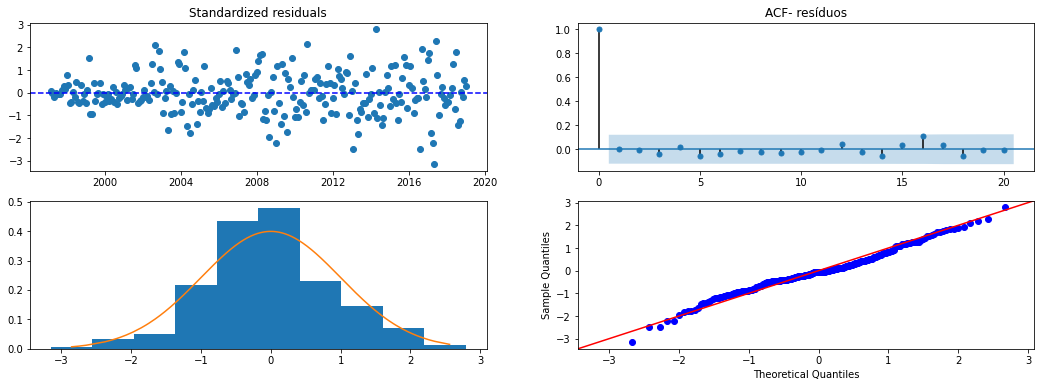

In [ ]:
# Gráficos do ajuste
res=model.fit()
res_standard=(res.resid-res.resid.mean())/np.sqrt(res.resid.var())#standardized residuals

fig,axs = plt.subplots(2, 2,figsize=(18,6))

axs[0,0].scatter(df.index[1:a], res_standard[1:a]) 
axs[0,0].axhline(y=0, color='b', linestyle='--')
axs[0,0].set_title('Standardized residuals')

x=plot_acf(res.resid, lags=20, ax=axs[0,1], title="ACF- resíduos");

axs[1,0].hist(res_standard[1:a], density=True);
x=np.sort(np.random.normal(0, 1, 1000))
axs[1,0].plot(x, stats.norm.pdf(x, 0, 1))
x1=sm.qqplot(res_standard[1:a], line ='45', ax=axs[1,1])


Nota-se que os resíduos seguem, aproximadamente, uma distribuição normal e são independentes, isto é, toda a informação continda no histórico da série foi considerado no modelo ARIMA (ver ACF, todos os lags são estatísticamente zero). Vale destacar que nos últimos anos da série há uma maior variabilidade nos resíduos. Em uma nova análise recomenda-se uma transformação dos dados, por exemplo, aplicar logaritmo.

#### Forecast
Vamos fazer as previsões para o último ano da série, com intervalo de confiança de 95%, para analisar a habilidade do modelo ARIMA (2,1,3) para fazer previsões

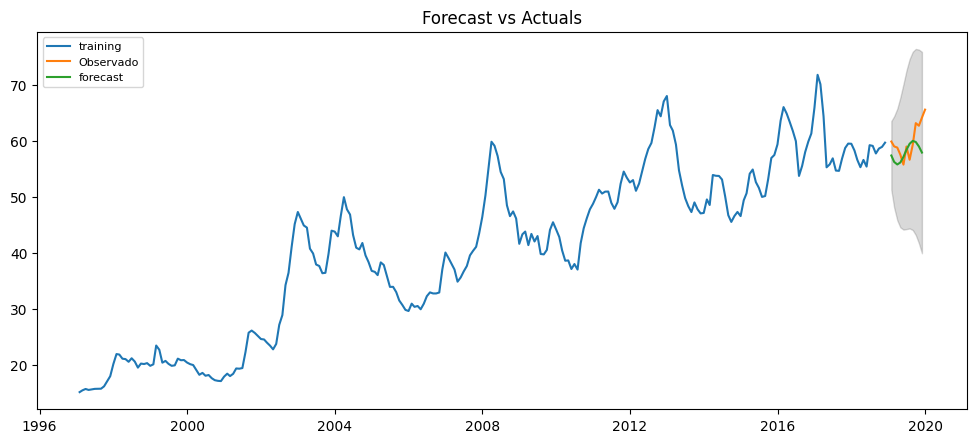

In [ ]:
#forecast h=12

# Create Training and Test
a=len(df)-12
train = df.valor[:(a-1)]
test = df.valor[a:]

# Build Model
model = ARIMA(train, order=(2,1,3))  
fitted = model.fit()  
#print(fitted.summary())

# Forecast

forecast = fitted.get_forecast(12)
forecast.predicted_mean
# Make as pandas series
fc_series = pd.Series(forecast.predicted_mean, index=test.index)
lower_series = pd.Series(forecast.conf_int(alpha = 0.05)["lower valor"], index=test.index)
upper_series = pd.Series(forecast.conf_int(alpha = 0.05)["upper valor"], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='Observado')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As previsões são boas? 

Vale ressaltar que o modelo ARIMA (2,1,3) está considerando que o instante $t$ está sendo influenciado (correlacionado) pelos valores da série nos instantes $t-1$ e $t-2$. Assim, quando fazemos a previsão para janeiro de 2019 temos informação(valor observado) da série do mês anterior, dezembro de 2019 $(t-1)$ e de novembro de 2019 $(t-2)$. No entanto, quando fazemos a previsão para fevereiro de 2020 já não temos informação (observada) do mês anterior, só temos um valor previsto pelo modelo, por esse motivo as previsões mais distantes apresentam maior erro (o intervalo de confiança aumenta) e seus valores tendem tendem a acompanhar o comportamento da tendência da série (modelada pela diferença). 

#### Acuracia do modelo

Para avaliar o desempenho do modelo para fazer previsões podemos usar algumas das seguintes medidas.
\
\
MAPE= $\dfrac{1}{N} \sum_t \dfrac{|forecast_t - observado_t|}{|observado_t|}$
\
\
MAE=$\dfrac{1}{N} \sum_t |forecast_t - observado_t|$
\
\
RMSE= $ \sqrt{\dfrac{1}{N} \sum_t (forecast_t - observado_t)^2}$,

em que $N$ é a quantidade de valores previstos pelo modelo. Vale ressaltar que estas métricas podem ser implementadas para selecionar o "melhor" modelo, por exemplo, selecionar $k$ modelos a partir do critério AIC e posteriormente selecionar o modelo que apresenta o menor valor em algum destes critérios. 

A seguir apresentam-se os valores das métricas para fazer as 12 previsões correspondentes ao último ano da série.

In [ ]:
# acuracia

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(forecast.predicted_mean, test.values)

{'mape': 0.040414480126268505,
 'me': -2.1143135096585817,
 'mae': 2.50286380419483,
 'mpe': -0.033556998652704895,
 'rmse': 3.21017231451055}

Nota-se que o erro médio abstoluto (MAE) das previsões é de 2.5 reais.

**Observação** Na prática, costuma-se definir intervalos de valores de $p$ e $q$, por exemplo $ p, q \in (0,1,..,6) $ ajustar modelos ARIMA(p,d,q) considerando todas as combinações possíveis e escolher o modelo que minimiza, por exemplo, o medida RMSE e além disso apresenta o menor AIC. O valor  $d$ do modelo ARIMA define-se a priori verificando se é necessário ou não diferenciar a série para torná-la estacionária.

#### Forecast one step 

É interessante analisar o desempenho do modelo para fazer previsões se atualizamos na base de dados a cada valor observado. As previsões melhoram?


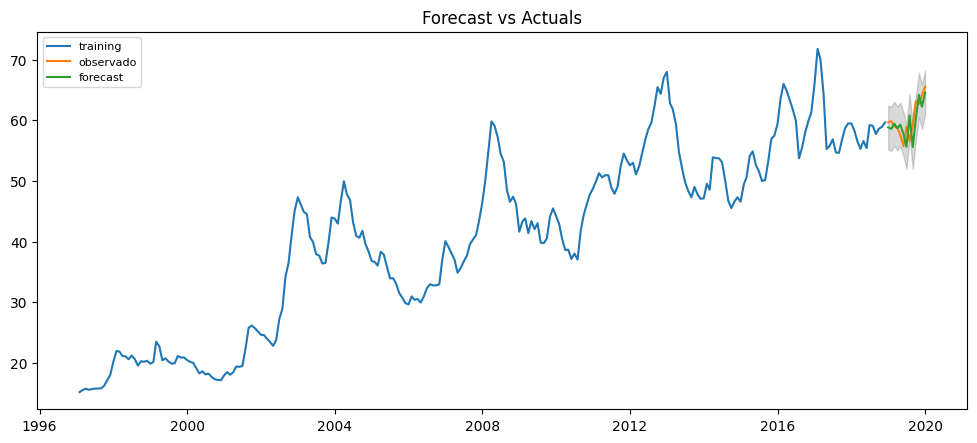

In [ ]:
# forecast atualizando cada valor observado

X = df.valor
size = 263
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
low1= list()
upper1= list()
forecast_one_step=pd.DataFrame()


for t in range(len(test)):
  model= ARIMA(history,order=(2,1,3))
  model_fit=model.fit()
  forecast = model_fit.get_forecast(1)
  yhat=forecast.predicted_mean
  low=forecast.conf_int(alpha = 0.05)[0,0]
  upper=forecast.conf_int(alpha = 0.05)[0,1]
  predictions.append(yhat)
  low1.append(low)
  upper1.append(upper)
  obs= test[t]
  history.append(obs)

forecast_one_step["forecast"]=predictions
forecast_one_step["low"]=low1
forecast_one_step["upper"]=upper1
forecast_one_step.index=test.index


plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='observado')
plt.plot(forecast_one_step["forecast"], label='forecast')
plt.fill_between(forecast_one_step.index, forecast_one_step["low"], forecast_one_step["upper"], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Nota-se que os valores previsto e observados são muito próximos quando atualizamos os valores conforme observados. O erro médio abstoluto (MAE) das previsões diminuiu para 1,92 reais.

In [ ]:
print("MAE:", np.mean(np.abs(forecast_one_step["forecast"] - test)))

MAE: [1.92163908]


#### **Autoarima**

Podemos implementar a biblioteca pmdarima para selecionar o "melhor" modelo usando algum critério de informação. 

**Cuidado**! Este pacote geralmente apresenta alguns erros uma vez que o pacote instala uma versão de *statsmodels*

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import pmdarima as pm
model_auto = pm.auto_arima(df.valor, d=1,information_criterion="aic",trace=1,stepwise=False)
print(model_auto.summary())

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1181.709, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1145.756, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1144.753, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1145.592, Time=0.17 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1146.240, Time=0.21 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1147.966, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1141.848, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1143.808, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1143.810, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1145.747, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1147.720, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1138.745, Time=0.59 sec
 ARIMA(3,1,0)(0,0,0)[1] i

Note que chegamos no mesmo modelo ARIMA(2,1,3).

### Exemplo 2

Vamos o analisar o conjunto de dados que descreve a produção mensal de leite (em libras por vaca) ao longo de 13 anos (1962-1975).

In [ ]:
df_2 = pd.read_csv('https://www.orlandoalbarracin.com.br/phyton/milk-production.csv', parse_dates=['date'], index_col='date')
df_2.head()

,value
date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


A seguir apresenta-se a série temporal e sua decomposição: tendência, sazonalidade. Os resíduos também são apresentados no último gráficos que representam os valores da série sem tendência nem sazonalidade. Nestes resíduos encontra-se toda a correlação serial que será modelada usando os termos autorregressivos e de médias móveis. Nota-se que a produção mensal de leite apresenta uma tendência crescente e um comportamento sazonal que se repete a cada 12 meses.

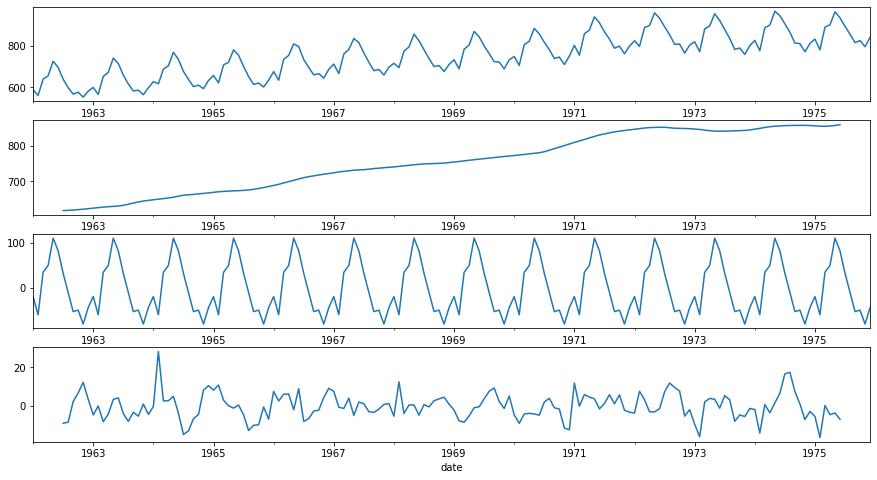

In [ ]:
# Decomposição da série

res=seasonal_decompose(df_2)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
res.observed.plot(ax=ax1)
res.trend.plot(ax=ax2)
res.seasonal.plot(ax=ax3)
res.resid.plot(ax=ax4)
plt.show()

Para modelar a tendência na série vamos diferenciar a série $$ \Delta Z_t = Z_t -Z_{t-1} $$. 
E para modelar a sazonalidade pode-se realizar uma diferença sazonal de defassagem 12, isto é, 
$$\Delta^{12} Z_t = Z_t -Z_{t-12} $$


A função de ACF da série original mostra que há um comportameto sazonal, após uma diferença observa-se que o ACF da série apresenta altos valores nos lags multiplos de 12 mostrando que há uma forte dependencia anual

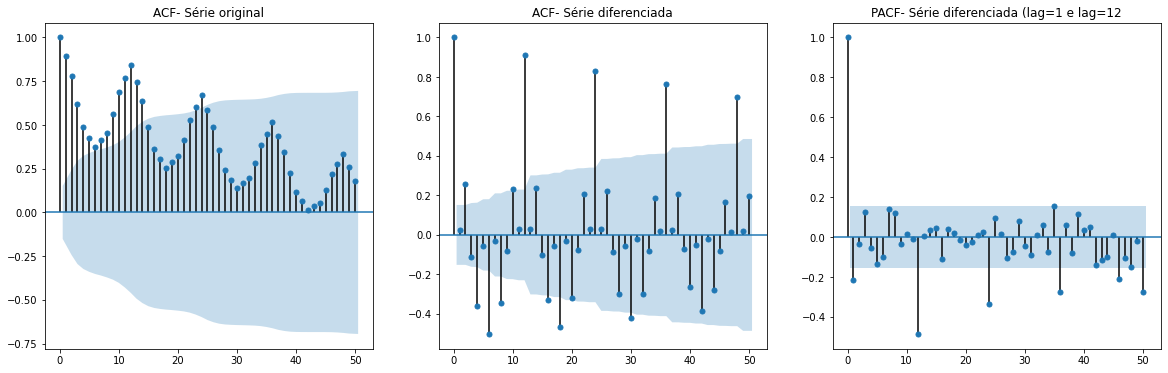

In [ ]:
# Aplicar diferenças para eliminar tendências e modelar a sazonalidade

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))

y=plot_acf(df_2, lags=50, ax=ax1, title="ACF- Série original")
y1=plot_acf(df_2.diff().dropna(), lags=50, ax=ax2, title="ACF- Série diferenciada")
y2=plot_pacf(df_2.diff().diff(12).dropna(), lags=50, ax=ax3, title="PACF- Série diferenciada (lag=1 e lag=12)")

Nota-se no gráfico do acf da série original que o decaimento é lento indicando que a série não é estacionária. Além disso, observa-se um comportamento sazonal na correlação serial comportamento esperado em séries sazonais. No gráfico do ACF da série após uma diferença (lag=1) observa-se que os dados estão altamente correlacionados com defasagens de ordem 12, comportamento observado na decomposição da série. Por fim, no gráfico PACF da série diferenciada para eliminar a tendência e sazonalidade observa-se que seria interessante considerar considerar num modelo ARIMA o efeito dos valores com defassagem 1, 12, 24 e 36.

Implementaremos neste exemplo o modelo SARIMA que permite incluir termos autorregressivos e de médias móveis sazonais. Deixaremos o último ano da série para avaliar a acuracia do modelo para fazer previsões. 

Vamos ajustar um modelo SARIMA(1,1,0)(3,1,0,12) considerando a análise da função PACF. Neste modelo estamos considerando que o instante $t-1$ deve ser considerado na modelagem ($p=1$), vamos realizar uma diferença para eliminar a tendência ($d=1$) e não estamos consideramos termos de médias móveis ($q=0$). Por fim, os últimos valores do modelo SARIMA indicam que vamos considerar um comportamento sazonal que se repete a cada 12 meses, o $P=3$ indica que os termos $(t-1(12)),(t-2(12))$ e $(t-3(12))$ serão considerados no modelo, $D=1$ indica que será realizada uma diferença de ordem 12 e $Q=0$ indica que não serão considerados termos de médias móveis sazonais.

In [ ]:
# Treinamento e teste 
train = df_2.iloc[:len(df_2)-12]
test = df_2.iloc[len(df_2)-12:]  # último ano para testar

In [ ]:
model = SARIMAX(train, order = (1, 1, 0),  seasonal_order =(3, 1, 0, 12)) # após uma diferença (lag=1 e lag=12)
result = model.fit()
print(result.summary());

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -488.068
Date:                            Fri, 27 Jan 2023   AIC                            986.136
Time:                                    19:09:51   BIC                           1000.950
Sample:                                01-01-1962   HQIC                           992.156
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2284      0.088     -2.599      0.009      -0.401      -0.056
ar.S.L12      -0.6498      0.082   

Nota-se que todas as estimativas dos parâmetros  de $Z_{t-1}$, $Z_{t-12}$, $Z_{t-24}$, $Z_{t-36}$ são estatísticamente diferente de zero. Vale destacar que para selecionar um "melhor" modelo pode-se considera um intervalo de valores para $p,q,P,Q$ e selecionar o modelo usando algum critério de decisão, por exemplo, AIC. 

A análise de resíduos confirma que o modelo está bem ajustado, não há tendências nos resíduos, eles se desenvolvem aleatoriamente em torno de zero, seguem aproximadamente uma distribuição normal e são não correlacionados como se observa na função ACF deles.

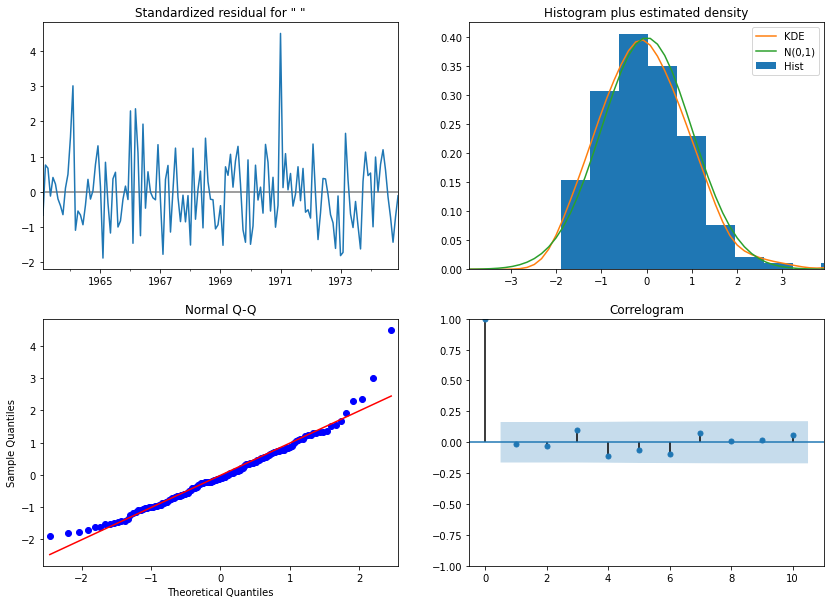

In [ ]:
diag=result.plot_diagnostics()
diag.set_size_inches((14, 10))
fig.tight_layout()

Previsões para os próximos 12 meses foram realizadas para avaliar a acuracia do modelo. 

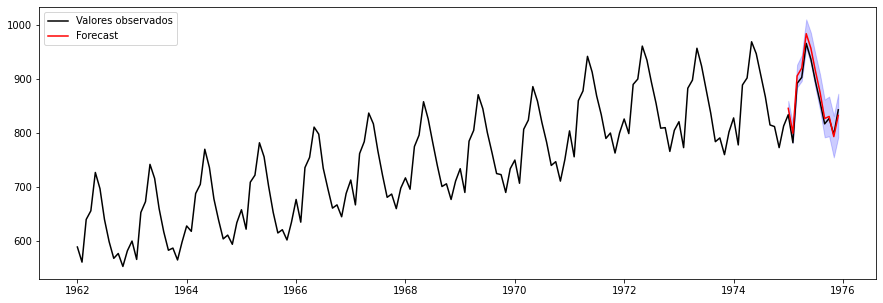

In [ ]:
#forecast 1 ano

#Checking prediction value with test
forecast = result.get_forecast(steps=len(test))
mean = forecast.predicted_mean
conf_int = forecast.conf_int()
d = mean.index

plt.figure(figsize=(15,5))
# Plot past  levels
plt.plot(df_2.index, df_2, label='Valores observados', color = 'black')
# Prediction Mean
plt.plot(d, mean, label='Forecast', color= 'red')
# Shade of space between  confidence intervals
plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2, color= 'blue')
# Plot legend 
plt.legend()
plt.show()

Observa-se que as previsões acompanham o comportamento da série. O erro absoluto médio é de 65,59. 

In [ ]:
# acuracia do modelo
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast=np.array(mean)
actual=np.array(test)
forecast_accuracy(forecast, actual)

{'mape': 0.07630612359830696,
 'me': 11.280260279412015,
 'mae': 65.5930359478068,
 'mpe': 0.01701488265973228,
 'rmse': 81.23824151852408}

# Reciclagem

Os modelos *Autoregressive Integrated Moving Average* (ARIMA) fornecem uma abordagem para a previsão de séries temporais incorporando na sua estrutura a correlação serial das observações e de erros aleatórios. Antes de introduzirmos os modelos ARIMA, devemos primeiro discutir o conceito de estacionariedade e a técnica de diferenciação de séries temporais.

MA são capazes de capturar a dependência entre as observações sem levar em conta a dependência entre observações mais distantes